<a href="https://colab.research.google.com/github/ValentineAlibert/Data-physics/blob/master/Notebook_Valentine_TIC_ID_388104525.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

first exoplanet :
TIC ID
## 388104525 

+ do the phase plot

# ***Beginner: Cutout of the TESS FFIs using Astrocut and Astroquery***

In [0]:
import numpy as np
!pip install astroquery
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

Get Coordinates of the Target Using Astroquery Catalogs

In [0]:
ticid = 388104525

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

    ID      Tmag   Jmag         ra               dec        objType
--------- ------- ------ ---------------- ----------------- -------
388104525 11.6035 10.924   55.93342240979 -65.1938512272516    STAR
650419407 19.8667    nan 55.9404793138343 -65.1938949361536    STAR
650419610 18.9745    nan 55.9260110476915 -65.1882654071435    STAR
388104522 17.4523 16.367 55.9419878222376 -65.1997148561897    STAR
388104523 15.1995 14.574 55.9187712557504 -65.1990332327806    STAR


In [0]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

11

In [0]:
coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-4-1      1      4   1
tess-s0002-3-4      2      3   4
tess-s0003-3-3      3      3   3
tess-s0004-4-2      4      4   2
tess-s0007-4-3      7      4   3
tess-s0010-4-4     10      4   4
tess-s0011-4-4     11      4   4


Request pixel timeseries cutout from TESS FFIs

In [0]:
hdulist = Tesscut.get_cutouts(coord, 20)


In [0]:
hdulist[0].info()
hdulist[0][0].header['SECTOR']
#hdulist[1].info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


1

Plot the First Image of the Time Series

In [0]:
# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

Text(0, 0.5, 'Image Row')

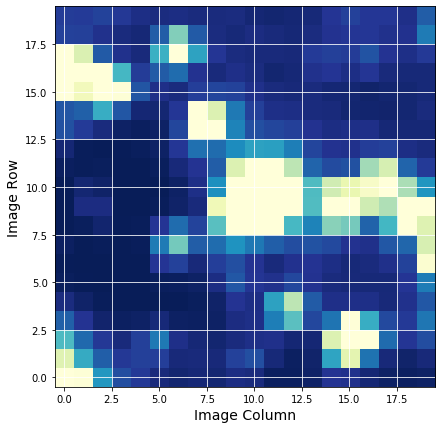

In [0]:
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)

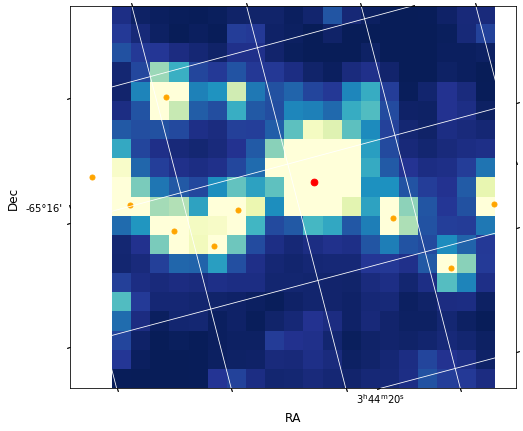

In [0]:
hdu2 = hdulist[1]

firstImage = hdu2[1].data['FLUX'][0]

wcs = WCS(hdu2[2].header)

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)


starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')

Create a Light Curve from the Cutout

In [0]:
def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux

Create a photometric time series using all the pixels in the image

Text(0.5, 1.0, 'Flux in Photometric Aperture')

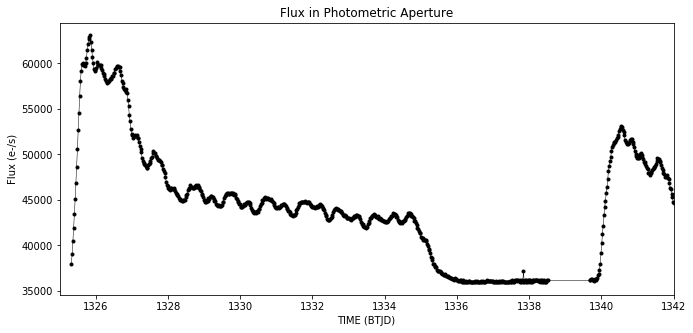

In [0]:
# Use all pixels in our aperture.
aperture = hdu1[2].data == 1

flux1 = make_lc(hdu1[1].data['FLUX'], aperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11,5))
plt.plot(time1, flux1, 'k.-', lw = .5)
plt.xlim(1325,1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Flux in Photometric Aperture')

stimate the background

Text(0.5, 1.0, 'Background Flux')

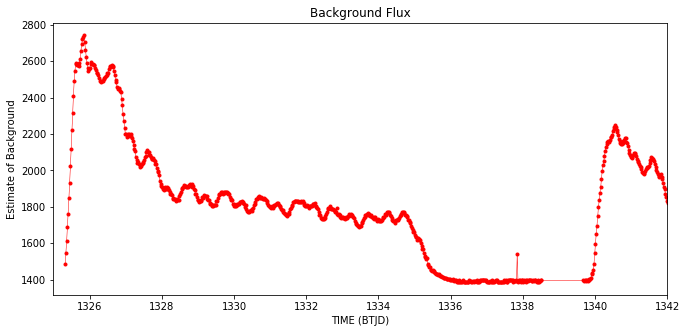

In [0]:
# Plot the flux change of the dimmest pixels by using percentile.
bkgAperture = hdu1[1].data['FLUX'][0] < np.percentile(hdu1[1].data['FLUX'][0], 5)

bkgFlux1 = make_lc(hdu1[1].data['FLUX'], bkgAperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11, 5))
plt.plot(time1, bkgFlux1, 'r.-', lw = .5)

plt.xlim(1325, 1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')

Subtract the background from the flux time series

Text(0.5, 1.0, 'Background Subtracted Flux')

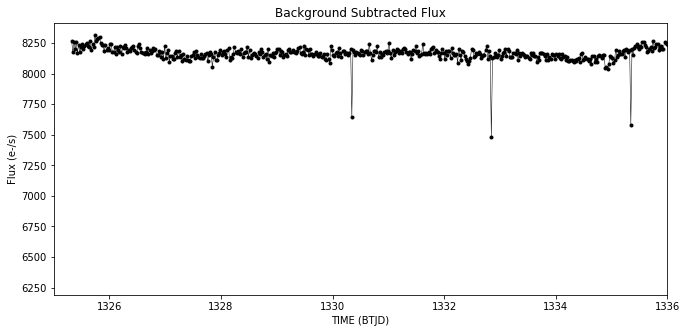

In [0]:
bkgSubFlux = flux1 - (bkgFlux1 * np.sum(aperture) / np.sum(bkgAperture) )

plt.figure(figsize = (11,5))
plt.plot(time1, bkgSubFlux,'.-k', lw = 0.5)

plt.xlim(1325, 1336)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Background Subtracted Flux')

## **Exoplanet Data and TESS Light Curves Using Python Requests**

In [0]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import pandas as p
from IPython.display import display, HTML

%matplotlib inline

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"
header={}

In [0]:

planet_name = "WASP-119 b"

url = planeturl + "/identifiers/"

myparams = {"name":planet_name}

r = requests.get(url = url, params = myparams, headers = header)
print(r.headers.get('content-type'))

application/json; charset=UTF-8


In [0]:
planet_names = r.json()
ticid = planet_names['tessID']
tce = planet_names['tessTCE']
planet_names

{'canonicalName': 'WASP-119 b',
 'dec': -65.193855,
 'keplerID': None,
 'keplerTCE': None,
 'planetNames': [],
 'ra': 55.933441,
 'starName': 'WASP-119',
 'tessID': 388104525,
 'tessTCE': 'TCE_1'}

In [0]:
url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()

print("Catalog 1: " + planet_prop[0]['catalog_name'])
print("Catalog 2: " + planet_prop[1]['catalog_name'])
planet_prop[0].keys()

Catalog 1: nexsci
Catalog 2: exoplanets.org


dict_keys(['canonical_name', 'exoplanetID', 'catalog_name', 'planet_name', 'disposition', 'modified_date', 'star_name', 'component', 'Rs', 'Rs_unit', 'Rs_upper', 'Rs_lower', 'Rs_ref', 'Rs_url', 'Ms', 'Ms_unit', 'Ms_upper', 'Ms_lower', 'Ms_ref', 'Ms_url', 'Fe/H', 'Fe/H_upper', 'Fe/H_lower', 'Fe/H_ref', 'Fe/H_url', 'stellar_gravity', 'stellar_gravity_upper', 'stellar_gravity_lower', 'stellar_gravity_ref', 'stellar_gravity_url', 'Teff', 'Teff_unit', 'Teff_upper', 'Teff_lower', 'Teff_ref', 'Teff_url', 'Vmag', 'Vmag_unit', 'Vmag_upper', 'Vmag_lower', 'Vmag_ref', 'Vmag_url', 'Jmag', 'Jmag_unit', 'Jmag_upper', 'Jmag_lower', 'Jmag_ref', 'Jmag_url', 'Hmag', 'Hmag_unit', 'Hmag_upper', 'Hmag_lower', 'Hmag_ref', 'Hmag_url', 'Kmag', 'Kmag_unit', 'Kmag_upper', 'Kmag_lower', 'Kmag_ref', 'Kmag_url', 'RA', 'DEC', 'distance', 'distance_unit', 'distance_upper', 'distance_lower', 'distance_ref', 'distance_url', 'Rp', 'Rp_unit', 'Rp_upper', 'Rp_lower', 'Rp_ref', 'Rp_url', 'Mp', 'Mp_unit', 'Mp_upper', 'Mp_l

In [0]:
print("WASP-18 b Properties")
print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )
print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))

WASP-18 b Properties
Stellar Mass 1.020000 M_sun
Planet Mass 1.230000 M_Jupiter
Planet Mass Reference: Maxted et al. 2016


In [0]:
url = dvurl + str(ticid) + '/tces/'
myparams = {"tce" : tce}

r = requests.get(url = url, params = myparams, headers = header)
sectorInfo = r.json()

sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
sectors

['s0001-s0003',
 's0002-s0002',
 's0001-s0001',
 's0011-s0011',
 's0001-s0006',
 's0001-s0009',
 's0003-s0003',
 's0001-s0002',
 's0007-s0007',
 's0004-s0004',
 's0001-s0013']

In [0]:
url = dvurl + str(ticid) + '/info/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tceInfo = r.json()
tceInfo.keys()
tceInfo['DV Data Header'].keys()

print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])

TIC: TIC 388104525
Planet Radius: 14.774970


In [0]:
# Get The data
url = dvurl + str(ticid) + '/table/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tce_data = r.json()

In [0]:
data = p.DataFrame.from_dict(tce_data['data'])
data.columns

Index(['TICID', 'EXTNAME', 'TIME', 'TIMECORR', 'CADENCENO', 'PHASE', 'LC_INIT',
       'LC_INIT_ERR', 'LC_WHITE', 'LC_DETREND', 'MODEL_INIT', 'MODEL_WHITE',
       'DATE_OBS', 'TESSDatetime', 'SECTORS'],
      dtype='object')

Text(0, 0.5, 'Relative Flux')

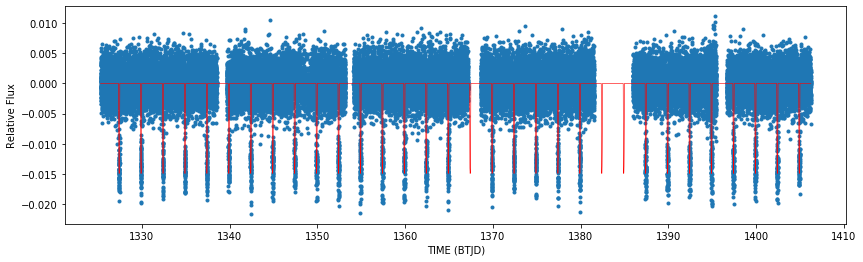

In [0]:
detrend = data['LC_DETREND']
model = data['MODEL_INIT']
time = data['TIME']

plt.figure(figsize=(14,4))
plt.plot(time,detrend,'.',lw=0.4)
plt.plot(time,model,'r-',lw=0.6)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Relative Flux')

In [0]:
url = dvurl + str(ticid) + '/phaseplot/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)

In [0]:
display(HTML(str(r.content.decode('utf-8'))))

Discussion
TIC ID
388104525 is a Confirmed Planet and its Name is WASP-119 b
et dire que c'est bizar comment les toris points sotn bizr parce qu'ils sont pas perodiquent et du coup juste random points

ca devrait etre un puit et c'est juste un pic , peut etre un probleme d'echelle ou Background Subtracted Flux vu qu'on a envoyé des poitns dans le backgorund ca a du enelever des infos, et donc peut etre bias

### **Beginner: Retrieve TESS Data Validation Products with Astroquery**

In [0]:
!pip install astroquery
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy import table
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [0]:
star_name = "WASP-119 b"

observations = Observations.query_object(star_name,radius = "0 deg")
obs_wanted = (observations['dataproduct_type'] == 'timeseries') & (observations['obs_collection'] == 'TESS')
print( observations[obs_wanted]['obs_collection', 'project','obs_id'] )

obs_collection project                        obs_id                       
-------------- ------- ----------------------------------------------------
          TESS    TESS      tess2018206045859-s0001-0000000388104525-0120-s
          TESS    TESS tess2018206190142-s0001-s0002-0000000388104525-00111
          TESS    TESS tess2018206190142-s0001-s0003-0000000388104525-00129
          TESS    TESS tess2018206190142-s0001-s0006-0000000388104525-00196
          TESS    TESS tess2018206190142-s0001-s0009-0000000388104525-00205
          TESS    TESS tess2018206190142-s0001-s0013-0000000388104525-00226
          TESS    TESS      tess2018234235059-s0002-0000000388104525-0121-s
          TESS    TESS      tess2018263035959-s0003-0000000388104525-0123-s
          TESS    TESS      tess2018292075959-s0004-0000000388104525-0124-s
          TESS    TESS      tess2019006130736-s0007-0000000388104525-0131-s
          TESS    TESS      tess2019112060037-s0011-0000000388104525-0143-s


In [0]:
data_products = Observations.get_product_list(observations[obs_wanted])
products_wanted = Observations.filter_products(data_products, 
                                    productSubGroupDescription=["DVT","DVM","DVS","DVR"])

print(products_wanted["productFilename"])
manifest = Observations.download_products(products_wanted)

                        productFilename                        
---------------------------------------------------------------
   tess2018206190142-s0001-s0001-0000000388104525-00106_dvr.pdf
   tess2018206190142-s0001-s0001-0000000388104525-00106_dvr.xml
   tess2018206190142-s0001-s0001-0000000388104525-00106_dvm.pdf
tess2018206190142-s0001-s0001-0000000388104525-01-00106_dvs.pdf
  tess2018206190142-s0001-s0001-0000000388104525-00106_dvt.fits
   tess2018206190142-s0001-s0002-0000000388104525-00111_dvr.pdf
   tess2018206190142-s0001-s0002-0000000388104525-00111_dvr.xml
   tess2018206190142-s0001-s0002-0000000388104525-00111_dvm.pdf
tess2018206190142-s0001-s0002-0000000388104525-01-00111_dvs.pdf
  tess2018206190142-s0001-s0002-0000000388104525-00111_dvt.fits
                                                            ...
  tess2018292093540-s0004-s0004-0000000388104525-00135_dvt.fits
   tess2019008025936-s0007-s0007-0000000388104525-00152_dvr.pdf
   tess2019008025936-s0007-s0007-0000000

In [0]:
print( manifest['Local Path'] )

                                                               Local Path                                                               
----------------------------------------------------------------------------------------------------------------------------------------
        ./mastDownload/TESS/tess2018206045859-s0001-0000000388104525-0120-s/tess2018206190142-s0001-s0001-0000000388104525-00106_dvr.pdf
        ./mastDownload/TESS/tess2018206045859-s0001-0000000388104525-0120-s/tess2018206190142-s0001-s0001-0000000388104525-00106_dvr.xml
        ./mastDownload/TESS/tess2018206045859-s0001-0000000388104525-0120-s/tess2018206190142-s0001-s0001-0000000388104525-00106_dvm.pdf
     ./mastDownload/TESS/tess2018206045859-s0001-0000000388104525-0120-s/tess2018206190142-s0001-s0001-0000000388104525-01-00106_dvs.pdf
       ./mastDownload/TESS/tess2018206045859-s0001-0000000388104525-0120-s/tess2018206190142-s0001-s0001-0000000388104525-00106_dvt.fits
   ./mastDownload/TESS/tess2018206190142-

In [0]:
def parse_manifest(manifest):
    """
    Parse manifest and add back columns that are useful for TESS DV exploration.
    """
    results = deepcopy(manifest)
    filenames = []
    sector_range = []
    exts = []
    for i,f in enumerate(manifest['Local Path']):
        file_parts = np.array(np.unique(f.split(sep = '-')))
        sectors = list( map ( lambda x: x[0:2] == 's0', file_parts))
        s1 = file_parts[sectors][0]
        try:
            s2 = file_parts[sectors][1]
        except:
            s2 = s1
        sector_range.append("%s-%s" % (s1,s2))
        path_parts = np.array(f.split(sep = '/'))
        filenames.append(path_parts[-1])
        exts.append(path_parts[-1][-8:])

    results.add_column(table.Column(name = "filename", data = filenames))
    results.add_column(table.Column(name = "sectors", data = sector_range))
    results.add_column(table.Column(name = "fileType", data = exts))
    results.add_column(table.Column(name = "index", data = np.arange(0,len(manifest))))
    
    return results

#Run parser and print
results = parse_manifest(manifest)
print(results['index','sectors','fileType'])

index   sectors   fileType
----- ----------- --------
    0 s0001-s0001 _dvr.pdf
    1 s0001-s0001 _dvr.xml
    2 s0001-s0001 _dvm.pdf
    3 s0001-s0001 _dvs.pdf
    4 s0001-s0001 dvt.fits
    5 s0001-s0002 _dvr.pdf
    6 s0001-s0002 _dvr.xml
    7 s0001-s0002 _dvm.pdf
    8 s0001-s0002 _dvs.pdf
    9 s0001-s0002 dvt.fits
  ...         ...      ...
   44 s0004-s0004 dvt.fits
   45 s0007-s0007 _dvr.pdf
   46 s0007-s0007 _dvr.xml
   47 s0007-s0007 _dvm.pdf
   48 s0007-s0007 _dvs.pdf
   49 s0007-s0007 dvt.fits
   50 s0011-s0011 _dvr.pdf
   51 s0011-s0011 _dvr.xml
   52 s0011-s0011 _dvm.pdf
   53 s0011-s0011 _dvs.pdf
   54 s0011-s0011 dvt.fits
Length = 55 rows


In [0]:
print(results['index', 'sectors', 'fileType'][results['sectors'] == "s0001-s0013"])

index   sectors   fileType
----- ----------- --------
   25 s0001-s0013 _dvr.pdf
   26 s0001-s0013 _dvr.xml
   27 s0001-s0013 _dvm.pdf
   28 s0001-s0013 _dvs.pdf
   29 s0001-s0013 dvt.fits


In [0]:
# Locate the file that has the data
want = (results['sectors'] == "s0001-s0013") & (results['fileType'] == "dvt.fits")
dvt_filename = manifest[want]['Local Path'][0]

# Print out the file info
fits.info(dvt_filename)

Filename: ./mastDownload/TESS/tess2018206190142-s0001-s0013-0000000388104525-00226/tess2018206190142-s0001-s0013-0000000388104525-00226_dvt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   ()      
  1  TCE_1         1 BinTableHDU     92   257086R x 10C   [D, E, J, E, E, E, E, E, E, E]   
  2  Statistics    1 BinTableHDU    157   257086R x 38C   [D, E, J, E, E, E, E, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


Text(0.5, 1.0, 'Data Validation Detrended Light Curve for WASP-119 b')

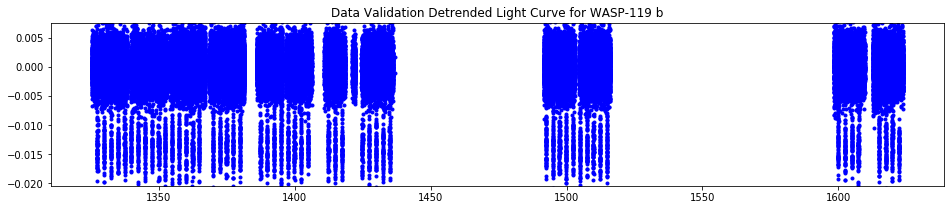

In [0]:
# Plot the detrended photometric time series in the first binary table. 
data = fits.getdata(dvt_filename, 1)
time = data['TIME']
relflux = data['LC_DETREND']

plt.figure(figsize = (16,3))
plt.plot (time, relflux, 'b.')
plt.ylim(1.2* np.nanpercentile(relflux, .5) , 1.2 * np.nanpercentile(relflux, 99.5))
plt.title('Data Validation Detrended Light Curve for %s' % (star_name))

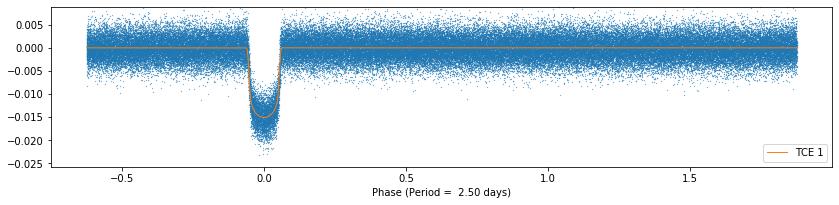

In [0]:
def plot_folded(phase, data, model, ext, period):
    isort = phase.argsort()
    
    plt.plot(phase[isort], data[isort], '.', ms = .5)
    plt.plot(phase[isort], model[isort], '-', lw = 1, label = "TCE %i" % ext)
    plt.xlabel('Phase (Period = %5.2f days)' % period)
    plt.ylim(1.5 * np.nanpercentile(data, .5) , 1.4 * np.nanpercentile(data,99.5))
    plt.legend(loc = "lower right")

plt.figure(figsize = (14,10))

nTCEs = fits.getheader(dvt_filename)['NEXTEND'] - 2

for ext in range(1, nTCEs + 1):
    data = fits.getdata(dvt_filename, ext)
    head = fits.getheader(dvt_filename, ext)
    period = head['TPERIOD']
    phase = data['PHASE']
    flux = data['LC_INIT']
    model = data['MODEL_INIT']
    plt.subplot(3, 1, ext)
    plot_folded(phase, flux, model, ext, period)



# **Intermediate: Finding Flares and Variable Stars in TASC Light Curves**

In [0]:
!pip install astroquery
# For querying for data
from astroquery.mast import Tesscut, Observations, Catalogs

# For manipulating data
import numpy as np
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.timeseries import LombScargle
from astropy.time import Time
import astropy.units as u

# For matplotlib plotting
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# For animation display
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='jshtml')

# For bokeh plotting
from bokeh import plotting
from bokeh.models import Span
plotting.output_notebook()

In [0]:
tic_id = 388104525
sector = 1


tpeak = 2458341.89227 # Julian Day

In [0]:
mission_res = Observations.query_criteria(obs_collection="TESS", 
                                          target_name=tic_id, 
                                          sequence_number=sector)
mission_res

<Table masked=True length=1>
dataproduct_type calib_level obs_collection ...    obsid       objID   
     str10          int64         str4      ...    str11       str11   
---------------- ----------- -------------- ... ----------- -----------
      timeseries           3           TESS ... 17000008491 17001689510

In [0]:
tasoc_res = Observations.query_criteria(target_name=tic_id, 
                                        obs_collection="HLSP", 
                                        project="TESS",
                                        sequence_number=sector)
tasoc_res['dataproduct_type',"obs_collection","target_name","t_exptime","filters",
          "provenance_name","project","sequence_number","instrument_name"]

<Table length=2>
dataproduct_type obs_collection target_name ... sequence_number instrument_name
     str10            str4          str9    ...      int64           str10     
---------------- -------------- ----------- ... --------------- ---------------
      timeseries           HLSP   388104525 ...               1      Photometer
      timeseries           HLSP   388104525 ...               1      Photometer

In [0]:
tasoc_prod = Observations.get_product_list(tasoc_res)
tasoc_prod["dataproduct_type", "description", "dataURI", "size"]

<Table length=2>
dataproduct_type description ...   size 
     str10           str4    ...  int64 
---------------- ----------- ... -------
      timeseries        FITS ... 1877760
      timeseries        FITS ...  161280

In [0]:
tasoc_manifest = Observations.download_products(tasoc_prod)
tasoc_manifest

INFO: Found cached file ./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00388104525-s01-c0120_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00388104525-s01-c0120_tess_v04_lc.fits with expected size 1877760. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00388104525-s01-c1800_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00388104525-s01-c1800_tess_v04_lc.fits with expected size 161280. [astroquery.query]


<Table length=2>
                                                                Local Path                                                                 ...
                                                                  str138                                                                   ...
------------------------------------------------------------------------------------------------------------------------------------------ ...
./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00388104525-s01-c0120_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00388104525-s01-c0120_tess_v04_lc.fits ...
./mastDownload/HLSP/hlsp_tasoc_tess_ffi_tic00388104525-s01-c1800_tess_v04_lc/hlsp_tasoc_tess_ffi_tic00388104525-s01-c1800_tess_v04_lc.fits ...

In [0]:
# Loading the short cadence light curve
hdu = fits.open(tasoc_manifest["Local Path"][0])
short_cad_lc = Table(hdu[1].data)
hdu.close()

# Loading the long cadence light curve
hdu = fits.open(tasoc_manifest["Local Path"][1])
long_cad_lc = Table(hdu[1].data)
hdu.close()

In [0]:
bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Detrended Lightcurve (TIC{tic_id})")

# Short cadence
bfig.circle(short_cad_lc["TIME"],short_cad_lc["FLUX_RAW"], fill_color="black",size=2, line_color=None)
bfig.line(short_cad_lc["TIME"],short_cad_lc["FLUX_RAW"], line_color='black')

# Long cadence
bfig.circle(long_cad_lc["TIME"],long_cad_lc["FLUX_RAW"], fill_color="#0384f7",size=6, line_color=None)
bfig.line(long_cad_lc["TIME"],long_cad_lc["FLUX_RAW"], line_color='#0384f7')

# Marking the flare (tpeak is in BJD, while the time column in the light curve is BTJD, so we must convert)
vline = Span(location=(tpeak - 2457000), dimension='height', line_color='#bf006e', line_width=3)
bfig.renderers.extend([vline])

# Labeling the axes
bfig.xaxis.axis_label = "Time (BTJD)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

In [0]:
#animation

coord = Observations.resolve_object(f"TIC {tic_id}")

In [0]:
cutout_hdu = Tesscut.get_cutouts(coordinates=coord, size=40, sector=1)[0]

In [0]:
cutout_hdu.info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 1600J, 1600E, 1600E, 1600E, 1600E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (40, 40)   int32   


In [0]:
cutout_table = Table(cutout_hdu[1].data)
cutout_table.columns

TableColumns([('TIME', <Column name='TIME' dtype='float64' length=1282>
                1325.323974609375
               1325.3447875976562
               1325.3656616210938
                1325.386474609375
               1325.4072875976562
               1325.4281616210938
                1325.448974609375
               1325.4697875976562
               1325.4906616210938
                1325.511474609375
               1325.5322875976562
               1325.5531616210938
                              ...
               1352.9284057617188
               1352.9492797851562
               1352.9700927734375
               1352.9909057617188
               1353.0117797851562
               1353.0325927734375
               1353.0534057617188
               1353.0742797851562
               1353.0950927734375
               1353.1159057617188
               1353.1367797851562
               1353.1575927734375),
              ('TIMECORR', <Column name='TIMECORR' dtype='float32' length=12

In [0]:
start_btjd = 1341.5
end_btjd = 1342.5

start_index = (np.abs(cutout_table['TIME'] - start_btjd)).argmin()
end_index = (np.abs(cutout_table['TIME'] - end_btjd)).argmin()

print(f"Frames {start_index}-{end_index} ({end_index-start_index} frames)")

Frames 721-769 (48 frames)


In [0]:
def make_animation(data_array, start_frame=0, end_frame=None, vmin=None, vmax=None, delay=50):
    """
    Function that takes an array where each frame is a 2D image array and make an animated plot
    that runs through the frames.
    
    Note: This can take a long time to run if you have a lot of frames.    
    Parameters
    ----------
    data_array : array
        Array of 2D images.
    start_frame : int
        The index of the initial frame to show. Default is the first frame.
    end_frame : int
        The index of the final frame to show. Default is the last frame.
    vmin : float
        Data range min for the colormap. Defaults to data minimum value.
    vmax : float
        Data range max for the colormap. Defaults to data maximum value.
    delay: 
        Delay before the next frame is shown in milliseconds.

    Returns
    -------
    response : `animation.FuncAnimation`
    """
    
    if not vmin:
        vmin = np.min(data_array)
    if not vmax:
        vmax = np.max(data_array)
        
    if not end_frame:
        end_frame = len(data_array) - 1 # set to the end of the array
        
    num_frames = end_frame - start_frame + 1 # include the end frame
        
    def animate(i, fig, ax, binarytab, start=0):
        """Function used to update the animation"""
        ax.set_title("Epoch #" + str(i+start))
        im = ax.imshow(binarytab[i+start], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)
        return im,
    
    # Create initial plot.
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(data_array[start_frame], cmap=plt.cm.YlGnBu_r, vmin=vmin, vmax=vmax)

    ani = animation.FuncAnimation(fig, animate, fargs=(fig, ax, data_array, start_frame), frames=num_frames, 
                                  interval=delay, repeat_delay=1000)
    
    plt.close()
    
    return ani

In [0]:
make_animation(cutout_table['FLUX'], start_index, end_index, vmax=700, delay=150)

In [0]:
#exploring variable stars
sources = Catalogs.query_object(catalog="TIC", objectname=f"TIC {tic_id}", radius=10*u.arcmin)
sources = sources[sources["Tmag"] < 12]
print(f"Number of sources: {len(sources)}")
print(sources)

Number of sources: 7
    ID           ra               dec        ... wdflag     dstArcSec     
--------- ---------------- ----------------- ... ------ ------------------
388104525   55.93342240979 -65.1938512272516 ...      0                0.0
316975790 55.7286101087489 -65.1905637419753 ...      0  309.5893939974912
388104536 55.7708230343087 -65.1393305788707 ...      0    314.57986044155
237914496 56.1752031537193 -65.1991088719746 ...      0  365.6341200448808
388104547 55.7670685579234 -65.1066699753557 ...      0 402.29508911550084
237914479 56.1579794540501 -65.2692862424027 ...      0  434.1127427310175
388104491 55.8993907654121 -65.3435003953983 ...      0  541.1697071236931


In [0]:
cutout_wcs = WCS(cutout_hdu[2].header)
cutout_img = cutout_table["FLUX"][start_index]

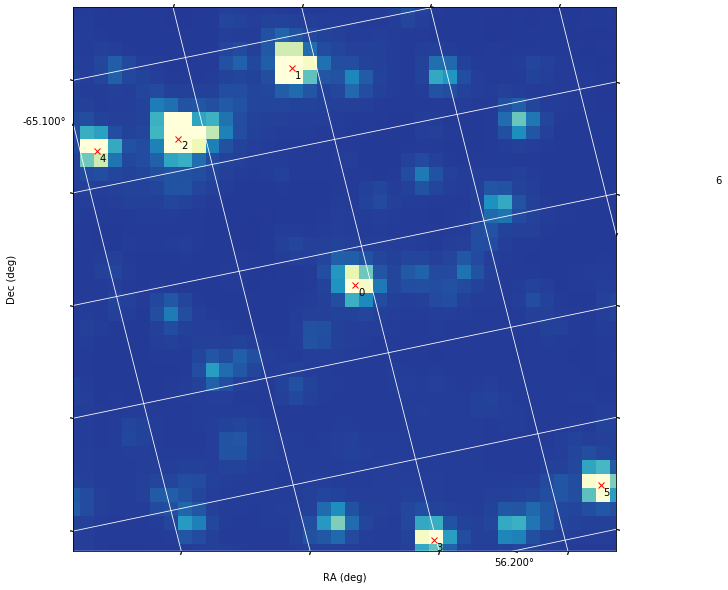

In [0]:
fig, ax = plt.subplots(subplot_kw={'projection':cutout_wcs})
fig.set_size_inches(10,10)
plt.grid(color='white', ls='solid')
    
# Setup WCS axes.
xcoords = ax.coords[0]
ycoords = ax.coords[1]
xcoords.set_major_formatter('d.ddd')
ycoords.set_major_formatter('d.ddd')
xcoords.set_axislabel("RA (deg)")
ycoords.set_axislabel("Dec (deg)")
ax.imshow(cutout_img, cmap=plt.cm.YlGnBu_r,vmin=0,vmax=700)
ax.plot(sources['ra'],sources['dec'],'x',transform=ax.get_transform('icrs'),color="red")

# Annotating the sources with their row nnumber in the sources table
for i,star in enumerate(sources):
    ax.text(star['ra']+0.01,star['dec'],i,transform=ax.get_transform('icrs'))

ax.set_xlim(0,cutout_img.shape[1]-1)
ax.set_ylim(cutout_img.shape[0]-1,0)

plt.show()

In [0]:
sources["ID","ra","dec"][4]

<Row index=4>
    ID           ra               dec       
  str11       float64           float64     
--------- ---------------- -----------------
388104547 55.7670685579234 -65.1066699753557

In [0]:
#get the variable star curve
variable_tic_id = sources["ID"][4]

variable_res = Observations.query_criteria(target_name=variable_tic_id, 
                                        obs_collection="HLSP", 
                                        filters="TESS")
print(f"Number of tasoc light curves for {variable_tic_id}: {len(variable_res)}\n")

        
variable_prod = Observations.get_product_list(variable_res[0])
variable_manifest = Observations.download_products(variable_prod)

Number of tasoc light curves for 388104547: 2



In [0]:
hdu = fits.open(variable_manifest["Local Path"][0])
variable_lc = Table(hdu[1].data)
hdu.close()

In [0]:
#plot the variable star light curve

bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Detrended Lightcurve (TIC{variable_tic_id})")

bfig.circle(variable_lc["TIME"],variable_lc["FLUX_RAW"], fill_color="black",size=4, line_color=None)
bfig.line(variable_lc["TIME"],variable_lc["FLUX_RAW"], line_color='black')

# Labeling the axes
bfig.xaxis.axis_label = "Time (BTJD)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

In [0]:
lomb = LombScargle(variable_lc["TIME"], variable_lc["FLUX_RAW"])
frequency, power = lomb.autopower(maximum_frequency=25)

In [0]:
#plot the periodrogram

bfig = plotting.figure(plot_width=850, plot_height=300, x_range=(0,25),
                       title=f"Periodogram (TIC{variable_tic_id})")

bfig.line(frequency, power, line_color='black')

# Labeling the axes
bfig.xaxis.axis_label = "Frequency (1/day)"
bfig.yaxis.axis_label = "Power"

plotting.show(bfig)

In [0]:
#phase highest and lowest frequency

dominant_freq = frequency[np.argmax(power)].value
print(f"The dominant priod: {1/dominant_freq*24:.3} hours")

The dominant priod: 2.67e+02 hours


In [0]:
bfig = plotting.figure(plot_width=850, plot_height=300, title=f"Phased Lightcurve (TIC{variable_tic_id})")

# Plotting the phased light curve
bfig.circle(variable_lc["TIME"]%(1/dominant_freq),variable_lc["FLUX_RAW"], fill_color="black",size=4, line_color=None)

# Plotting the periodic fit
t_fit = np.linspace(0,1/dominant_freq,100)
bfig.line(t_fit, lomb.model(t_fit, dominant_freq), color='#1b9f00', line_width=2)

# Labeling the axes
bfig.xaxis.axis_label = "Phase (days)"
bfig.yaxis.axis_label = "Flux"

plotting.show(bfig)

# **Interactively inspecting Target Pixel Files and Lightcurves**

04-interact-with-lightcurves-and-tpf.ipynb
spacetelescope lightkruve 
tessworkshop_tutorials/lightkurve/workshop


In [15]:
!pip install 'lightkurve'
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
from lightkurve import search_targetpixelfile
f = search_targetpixelfile(388104547, quarter=0).download()

Could not resolve 388104547 to a sky position.
/usr/local/lib/python3.6/dist-packages/lightkurve/search.py:225: LightkurveWarning: Cannot download from an empty search result.
  LightkurveWarning)


In [20]:
tpf.interact(notebook_url='localhost:8893')

Bokeh show_app is currently unsupported


I tried to run the bokeh show app, but doesn't seem to run, i left it in the notebook in case i can resolve the problem later because the resulst was itneesting, it explaines the tpf.interact() tool that accomplishes the goal of interactively inspecting the TPFs and lightcurve simultaneously.
You can now click on individual pixels and the aperture photometry updates. The mask can be defined with either individual clicking of pixels, or clicking and dragging a box over a rectangular set of pixels. Deselection of individual pixels also works-- simply re-click a pixel that you wish to take away from your mask.

Building different apertures with **lightkurve**

In [0]:
import lightkurve as lk
search = lk.search_targetpixelfile("Pi Mensae", sector=1)
tpf = search.download()

In [0]:
# Loop through three different threshold values to build three masks
for idx, threshold in enumerate([1, 10, 100]):
    # Append them to a list
    apers.append(tpf.create_threshold_mask(threshold=threshold))

In [0]:
apers[0]

In [0]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Loop through the aperture masks
for idx, aper in enumerate(apers):
    # Use lightkurve to plot each tpf with each mask.
    tpf.plot(ax=axs[idx], aperture_mask=aper)